In [96]:
import json
import os
import re
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statistics
import statsmodels.api as sm
from pprint import pprint

# %matplotlib inline
warnings.filterwarnings('ignore')

In [97]:
sys.path.append(os.path.join('..', 'src'))

In [98]:
import importlib
import utils, model
importlib.reload(model)
importlib.reload(utils)
from utils import build_data_dict
from model import timer, measure_prediction_time, apply_ml_model, save_model_parameters, save_model_metrics
from model import get_folders

import params
importlib.reload(params)
from params import ProjectParameters

# set model parameters

In [99]:
# target_type = ProjectParameters().target_type
scoring = ProjectParameters().scoring
# print('SELECTED TARGET AND SCORING ARE:', target, ',', scoring)

# Data capture

In [100]:
inputs, models_reports, model_outputs, reports = get_folders()

data_list = ['X_train', 'X_test', 'X_train_oh', 'X_test_oh', 'y_train', 'y_test']
dfs_dict = build_data_dict(inputs, data_list)

loading data into dictionary


In [101]:
for data in data_list:
    print('shape for {}:'.format(data), dfs_dict[data].shape)

shape for X_train: (32534, 13)
shape for X_test: (16281, 13)
shape for X_train_oh: (32534, 96)
shape for X_test_oh: (16281, 96)
shape for y_train: (32534, 1)
shape for y_test: (16281, 1)


In [102]:
target_type = 'binary'

# Machine Learning

In [103]:
import warnings
warnings.filterwarnings('ignore')
# warnings.simplefilter('ignore')

In [104]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer as Imputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.metrics import classification_report, roc_curve, precision_recall_curve, confusion_matrix
# from sklearn.metrics import accuracy_score, log_loss, f1_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Pipelines with preprocessing and crossvalidation

## Baseline classifiers
We could always start with simple baselines. For regression, we could use a simple Lasso with no hyperparameter tuning. Lasso is L1 regularization and penalizes high complexity of the model.

In [105]:
ml_dict, time_dict = {'standard': {}, 'smote': {}, 'no_col': {}}, {'standard': {}, 'smote': {}, 'no_col': {}}

### 1) random guess using mean

In [106]:
dfs_dict['y_train'].head()

,y
id,
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [107]:
y_pred = [statistics.mean(np.array(dfs_dict['y_train']['y']))]*len(dfs_dict['y_test'])

### 1) using Logistic Regression

In [109]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression

In [110]:
ml_dict = {}
# for key in ['standard', 'skewed', 'no_col', 'no_col_skewed', 'oh']:
for key in ['standard']:
    ml_dict[key] = {}
ml_dict

{'standard': {}}

In [111]:
ml_model = 'baseline'

# if  target_type == 'regression':
#     parameters = {'model__alpha': [1], 
#               'model__random_state':[42]}
#     model = Lasso()
#     do_transform_label = 'log'
if  target_type == 'binary':
    parameters = {'model__random_state':[42]}
    model = LogisticRegression()
    do_transform_label = None
clf, train_time, prediction_time = apply_ml_model(
    dfs_dict, dfs_dict['y_train'], model, parameters, scoring, 
    encoding='one-hot', do_build_polynomals=False, do_transform_label=do_transform_label, do_treat_skewness=False,
    imputation=Imputer(strategy='median'), scaler=StandardScaler(),
    testing=False)

key= 'standard'
if scoring == 'neg_mean_squared_error':
    clf.best_score_ = -clf.best_score_
ml_dict[key][ml_model] = {}
ml_dict[key][ml_model]['best_params'] = clf.best_params_
ml_dict[key][ml_model]['best_score'] = clf.best_score_
ml_dict[key][ml_model]['train_time'] = train_time
ml_dict[key][ml_model]['prediction_time'] = prediction_time

test type: False


### ML models

Our metric to compare models will be mean squared error. It penalizes outliers more than mean absolute error.

# load results

In [112]:
def load_json_results(filename):
    filepath = os.path.join(model_outputs, filename+'.json')
    with open(filepath, 'r') as file:
        return json.load(file)

In [113]:
ml_models = ['reg', 'tree_randomforest']
# ml_models = ['reg_elasticnet']
for ml_model in ml_models:
    json_results = load_json_results(ml_model)
    for key,value in json_results.items():
        ml_dict[key][ml_model] = value[ml_model]

## xgboost

In [114]:
ml_model = 'tree_xgboost'
json_results = load_json_results(ml_model)
for key,value in json_results.items():
    ml_dict[key][ml_model] = value[ml_model]

In [115]:
pprint(ml_dict)

{'standard': {'baseline': {'best_params': {'model__random_state': 42},
                           'best_score': 0.8506178713354215,
                           'prediction_time': 0.0005,
                           'train_time': 6.102996},
              'reg': {'best_params': {'model__C': 0.01,
                                      'model__penalty': 'l2',
                                      'model__random_state': 42},
                      'best_score': 0.844562622172693,
                      'prediction_time': 0.0004968,
                      'train_time': 16.309028},
              'tree_randomforest': {'best_params': {'model__max_features': None,
                                                    'model__n_estimators': 200,
                                                    'model__random_state': 42},
                                    'best_score': 0.8215713589153747,
                                    'prediction_time': 0.0077786,
                                    'train_tim

# compare results

In [116]:
import operator
def plot_user_metric(results, user_metric):
    file = '06metric_'+user_metric+'.jpg'
    tup_results = sorted(results.items(), key=operator.itemgetter(1))

    N = len(results)
    ind = np.arange(N)  # the x locations for the groups
    width = 0.40       # the width of the bars

    fig = plt.figure(figsize=(8,2))
    ax = fig.add_subplot(111)
    rects = ax.bar(ind+0.5, list(zip(*tup_results))[1], width,)
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 
                1.005*height, 
                '{0:.4f}'.format(height), 
                ha='center', 
                va='bottom',)

    ax.set_xlabel('ML model')
    
    ax.set_ylabel(user_metric)
    ax.set_title("{} comparison".format(user_metric))
        
    ax.set_xticks(ind + width/2.)
    ax.set_xticklabels(list(zip(*tup_results))[0], rotation=22)
    print("Order of models:", list(zip(*tup_results))[0])
    
    plt.plot()
    plt.savefig(os.path.join(reports,file), bbox_inches = "tight")

In [118]:
dic_results = {}
for key,val in ml_dict['standard'].items():
    ml_model = re.sub('clf_.*_(.*)', r'\1', key)
    dic_results[ml_model] = val['best_score']

Order of models: ('tree_randomforest', 'reg', 'baseline', 'tree_xgboost')


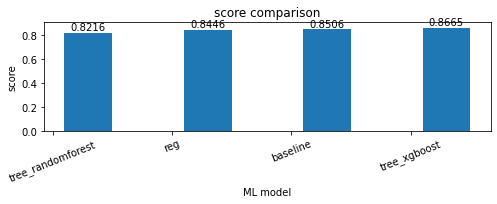

In [119]:
plot_user_metric(dic_results, 'score')

# time and computational complexity
This objective of this section is to simulate complexity of ML models used for this dataset. The ideal approach would be to check computational complexity using Big-O notation or picking different sizes of dataset to see how complexity changes. The absolute value itself can be misleading if we forget that it depends on computer power. Nevertheless, we can do a basic comparison from those models here. The final model should not be based only on score, but also on how long it takes to train, and, for real time applications, how long it takes to give a prediction. Other issues might also be important, such as interpretability, labor cost to build/tune the algorithm and ease of deployment.

#### Time comparison during training

In [120]:
dic_time = {}
for key,val in ml_dict['standard'].items():
    ml_model = re.sub('clf_.*_(.*)', r'\1', key)
    dic_time[ml_model] = val['train_time']

Order of models: ('tree_xgboost', 'baseline', 'reg', 'tree_randomforest')


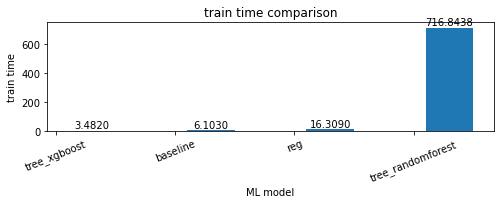

In [121]:
plot_user_metric(dic_time, 'train time')

#### Time comparison during prediction

In [122]:
dic_pred = {}
for key,val in ml_dict['standard'].items():
    ml_model = re.sub('clf_.*_(.*)', r'\1', key)
    dic_pred[ml_model] = val['prediction_time']

Order of models: ('tree_xgboost', 'reg', 'baseline', 'tree_randomforest')


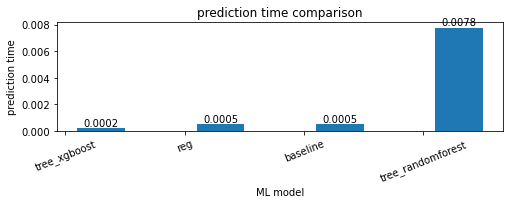

In [123]:
plot_user_metric(dic_pred, 'prediction time')